In [1]:
from tensorflow.test import gpu_device_name
gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Analyzing Cellular Populations using CATCH - a tutorial:

# 0. Introduction

Cells occupy a hierarchy of transcriptional identities which is difficult to study in an unbiased manner when perturbed by disease. To identify, characterize, and compare clusters of cells, we present CATCH, a coarse graining framework that learns the cellular hierarchy by applying a deep cascade of manifold-intrinsic diffusion filters. CATCH includes a suite of tools based on the connection we forge between topological data analysis and data diffusion geometry to identify salient levels of the hierarchy, automatically characterize clusters and rapidly compute differentially expressed genes between clusters of interest. When used in conjunction with MELD (https://github.com/KrishnaswamyLab/MELD), CATCH has been shown to identify rare popultions of pathogenic cells and create robust disease signatures.

# 1. Installation and Setup: 

First, let's import CATCH along with all our other packages and proceed with analysis. If you haven't already, install the CATCH package using pip as follows (requirements located at https://github.com/KrishnaswamyLab/CATCH)


In [5]:
!pip install git+https://github.com/KrishnaswamyLab/CATCH

  Cloning https://github.com/KrishnaswamyLab/CATCH to /tmp/pip-req-build-ayk0o950
  Running command git clone -q https://github.com/KrishnaswamyLab/CATCH /tmp/pip-req-build-ayk0o950
ERROR: Operation cancelled by user


In [6]:
import numpy as np
import pandas as pd
import graphtools
from CATCH import catch
import matplotlib.pyplot as plt
import scprep

import phate
import sklearn

import tasklogger
import collections
import warnings
from collections import defaultdict

from scipy.spatial.distance import pdist, cdist, squareform
warnings.simplefilter("ignore")

# 2. Loading and Pre-processing Data

In this section we will download 10X human Peripheral Blood Mononuclear Cell (PBMC) data to your local computer and pre-process it for analysis with CATCH.

In [7]:
import os

data_dir = "/content/drive/MyDrive/Colab Notebooks/catch_data" # enter path to data directory here (this is where you want to save 10X data)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

file_name = '10X_pbmc_data.h5'
file_path = os.path.join(data_dir, file_name)

In [ ]:
URL = 'https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc4k/pbmc4k_raw_gene_bc_matrices_h5.h5'

scprep.io.download.download_url(URL, file_path)

In [8]:
data = scprep.io.load_10X_HDF5(file_path, gene_labels='both')

data.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
AAACCTGAGAAACCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGAAACCGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGAAACCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGAAACGAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGAAACGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
type(data)

pandas.core.frame.DataFrame

Now that we have loaded the data, we will remove cells with low transcript counts (less than 1000 counts per cell) and unexpressed genes (expressed in less than 5 cells):

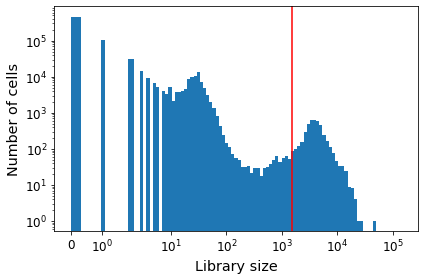

In [10]:
scprep.plot.plot_library_size(data, cutoff=1500)

In [11]:
data = scprep.filter.filter_library_size(data, cutoff=1500, keep_cells='above')
data = scprep.filter.filter_rare_genes(data)

In [12]:
data.shape, type(data)

((4298, 15401), pandas.core.frame.DataFrame)

Finally, we will library size normalize and square root transform the expression data as is standard in single cell analysis:

In [ ]:
data_norm, libsize = scprep.normalize.library_size_normalize(data, return_library_size=True)

In [ ]:
data_sqrt = scprep.transform.sqrt(data_norm)

data_sqrt.head()

,RP11-34P13.7 (ENSG00000238009),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP4-669L17.10 (ENSG00000237094),RP11-206L10.9 (ENSG00000237491),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),NOC2L (ENSG00000188976),KLHL17 (ENSG00000187961),PLEKHN1 (ENSG00000187583),...,MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),BX004987.4 (ENSG00000278704),AC145212.2 (ENSG00000274847),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC007325.4 (ENSG00000278817),AL354822.1 (ENSG00000278384),AC004556.1 (ENSG00000276345),AC240274.1 (ENSG00000271254)
AAACCTGAGAAGGCCT-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,4.154662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGACAGACC-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,6.573422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGATAGTCA-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,6.449217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGCGCCTCA-1,0.0,0.0,0.0,0.0,2.077481,0.0,0.0,2.077481,0.0,0.0,...,0.0,5.876003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGCATGGT-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,3.661874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we'll run the PHATE (https://www.nature.com/articles/s41587-019-0336-3), a dimensionality reduction algorithm previously developed by the Krishnaswamy lab to produce powerful visualizations.

Calculating PHATE...
  Running PHATE on 4298 observations and 15401 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.58 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.44 seconds.
  Calculated graph and diffusion operator in 13.96 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.77 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.25 seconds.
  Calculated landmark operator in 16.80 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 4.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.91 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.70 seconds.
Calculated PHATE in 42.70 seconds.


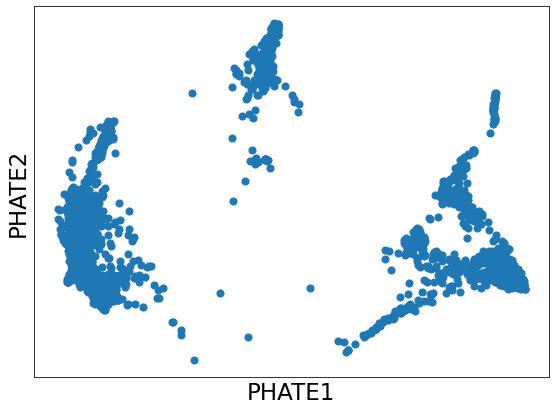

In [ ]:
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_sqrt)

scprep.plot.scatter2d(
    data_phate,
    fontsize=16,
    s=50,
    legend=False,
    ticks=False,
    label_prefix="PHATE",
    figsize=(8, 6),
)

# 3. Running CATCH on our dataset

First, we run the CATCH condensation process on the data as follows:

1. Compute the CATCH operator on our dataset
2. Identify clustering granularities amenable for analysis via topological activity analysis
3. Visualize condensation homology
4. Visualize our datasets with the chosen levels of resolution
5. Compute differentially expressed genes between clusters using condensed transport

In [ ]:
catch_op = catch.CATCH(knn=30, random_state=18, n_pca=50, n_jobs=1)
catch_op.fit(data_sqrt.sparse.to_dense())

Calculating PCA...
Calculated PCA in 8.86 seconds.
Calculating Diffusion Condensation...
  Calculating Condensation Parameters...
  Calculated Condensation Parameters in 0.94 seconds.
Calculated Diffusion Condensation in 91.50 seconds.


Next, we identify granularities for downstream analysis using topological
activity analysis:

In [ ]:
levels = catch_op.transform()

Calculating Topological Activity...
Calculated Topological Activity in 0.02 seconds.


We can now visualize the topological activity and identify granularities which partition single cells into meaningul, stable clusters:

[-119 -112 -107 -102  -97  -94  -85  -82  -79  -74  -63  -56  -54  -40
  -36  -29  -16  -10]


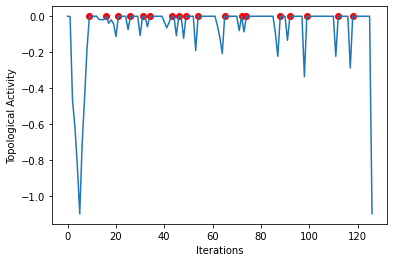

In [ ]:
print(levels)

plt.plot(catch_op.gradient)
plt.xlabel("Iterations")
plt.ylabel("Topological Activity")
plt.scatter(len(catch_op.NxTs)+levels, catch_op.gradient[levels+1], c='r')

plt.show()

Finally, we can visualize the CATCH computed clusters on our initial PHATE embedding across stable granularities:

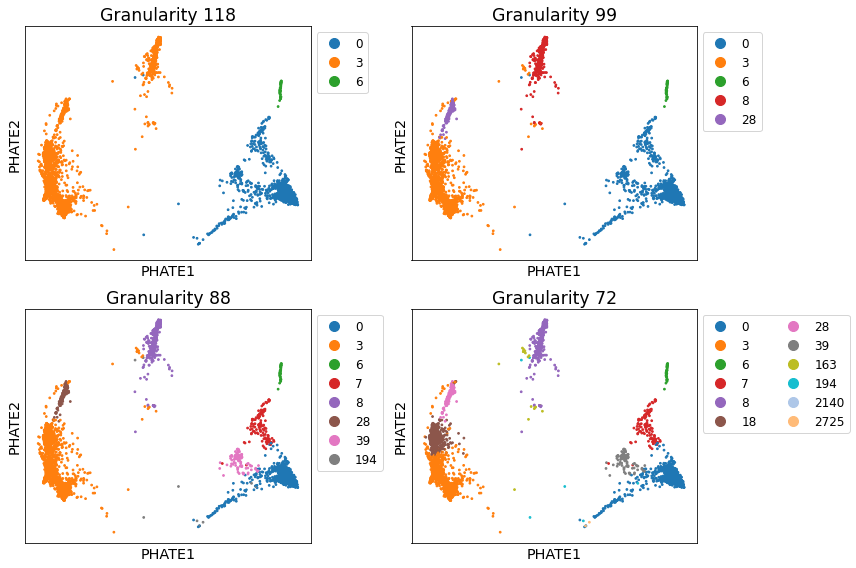

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):    
    scprep.plot.scatter2d(data_phate, c=catch_op.NxTs[levels[-2*i-1]], legend_anchor=(1,1), ax=ax,
                          title='Granularity '+str(len(catch_op.NxTs)+levels[-2*i-1]),
                          xticks=False, yticks=False, label_prefix="PHATE", fontsize=10, s=3)

fig.tight_layout()

Now we can compute the condensation homology and visualize some of these stable clusters on the tree to help us identify optimal granularities levels for downstream analysis:

In [ ]:
tree = catch_op.build_tree()

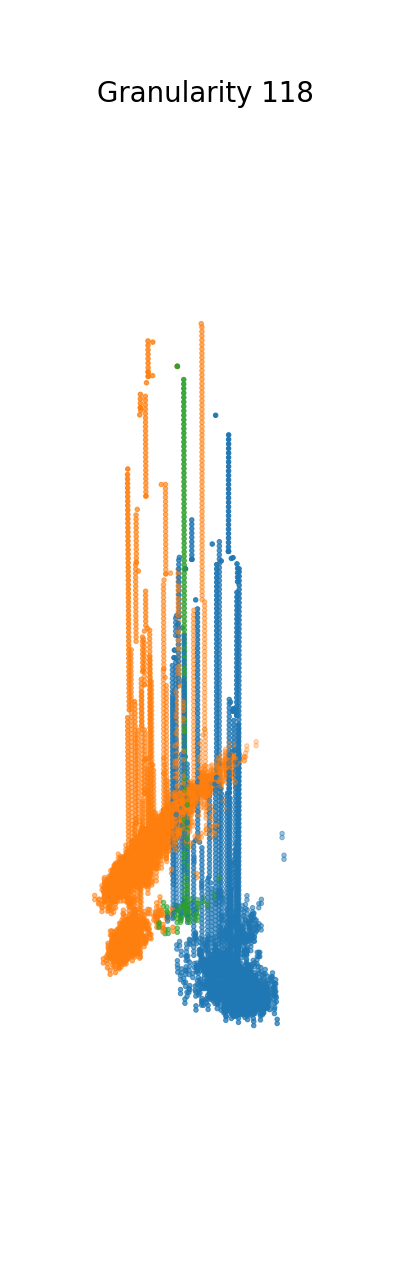

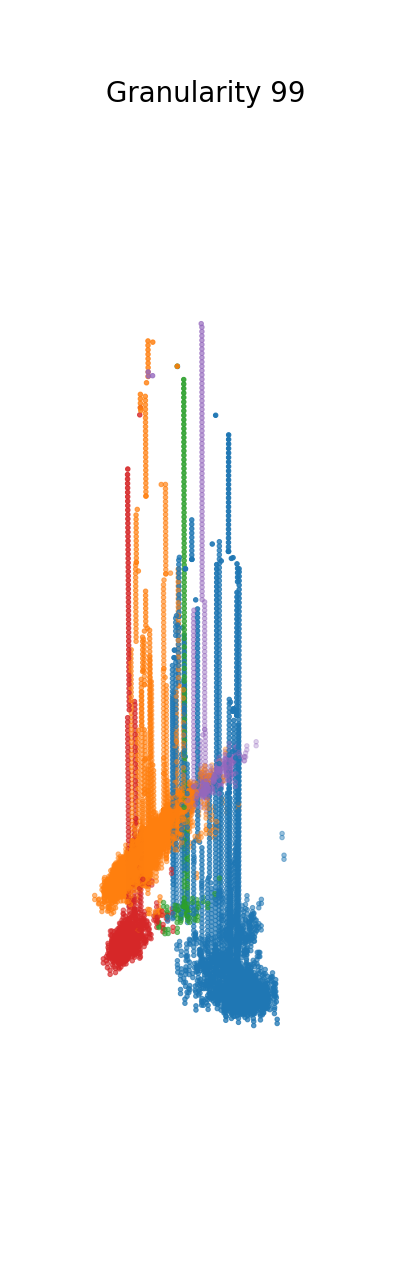

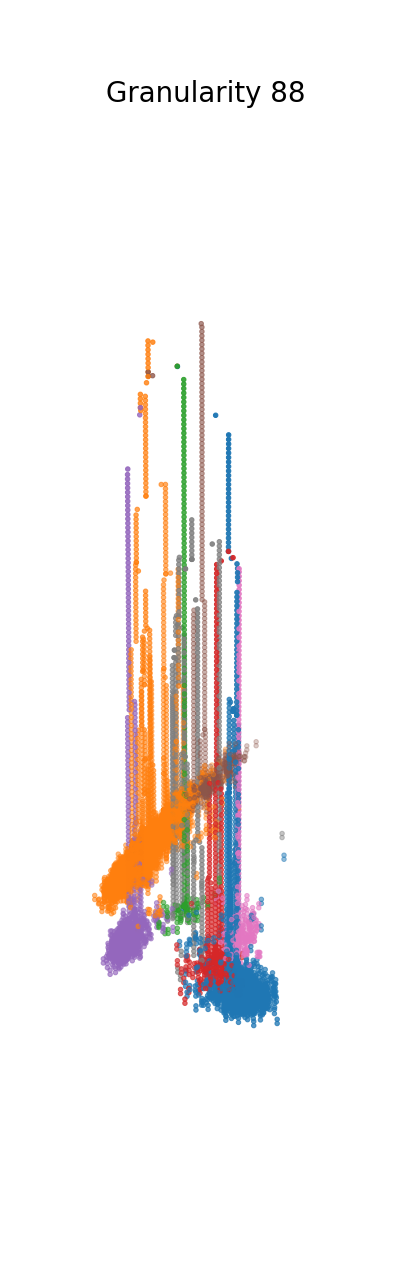

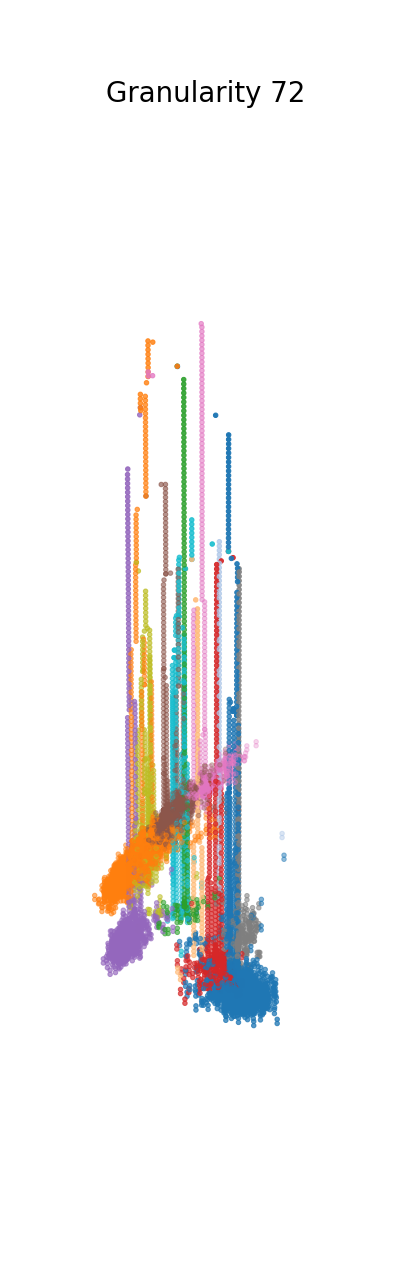

In [ ]:
for i in range(4):
    tree_clusters = catch_op.map_clusters_to_tree(catch_op.NxTs[levels[-2*i-1]])
    
    ax = scprep.plot.scatter3d(tree, c = tree_clusters, title = 'Granularity '+str(len(catch_op.NxTs)+levels[-2*i-1]),
                      fontsize=16, s = 20, legend = False,
                      ticks=False, label_prefix="PHATE", figsize=(6,18))
    ax.set_axis_off()

We often find that rotating the condensation homology plot allows for the best visualization of cluster seperation (use command scprep.plot.rotate_scatter3d).

## Coarse grained analysis of cellular subsets

Since granularity level 98 seems like a reasonable seperation of the coarse clusters present within the data, we will continue differenential expression analysis with these sets of clusters. Please feel free to play around with granularity levels however!

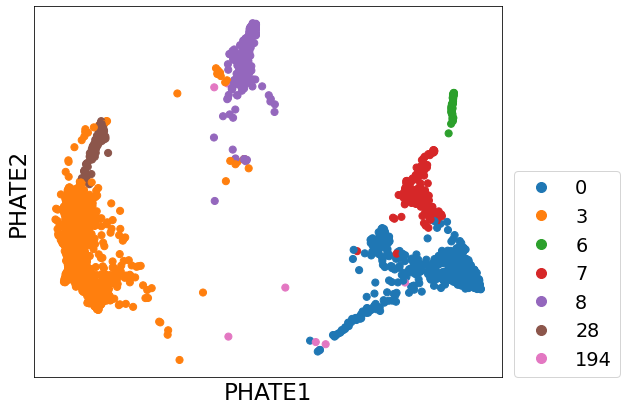

In [ ]:
scprep.plot.scatter2d(
    data_phate,
    c = catch_op.NxTs[98],
    fontsize=16,
    s=50,
    legend=True,
    ticks=False,
    label_prefix="PHATE",
    figsize=(9, 6),
    legend_loc=(1.025,0)
)

Now, in order to identify cluster specific genes, we can perform differential expression analysis between cellular populations of interest through condensed transport analysis. The condensed transport command is a little involved, cluster_{1,2} denote the cluster label assigned by CATCH at granularities level_{1,2} respectively. For instance in the following command, we are comparing cluster 0 to cluster 3 both of which are found at granularity 98. Feel free to play around with cluster labels and granularities!

In [ ]:
diff_genes_0_3 = catch_op.condensed_transport(cluster_1=0, cluster_2=3, level_1=98, level_2=98)
diff_genes_0_3 = diff_genes_0_3.sort_values(by=['Signed Transport'])

Calculating Transporting Genes...
Calculated Transporting Genes in 0.03 seconds.


Now we can visualize most differntially expressed genes between clusters 0 and 3:

Higher expressed in Cluster 3


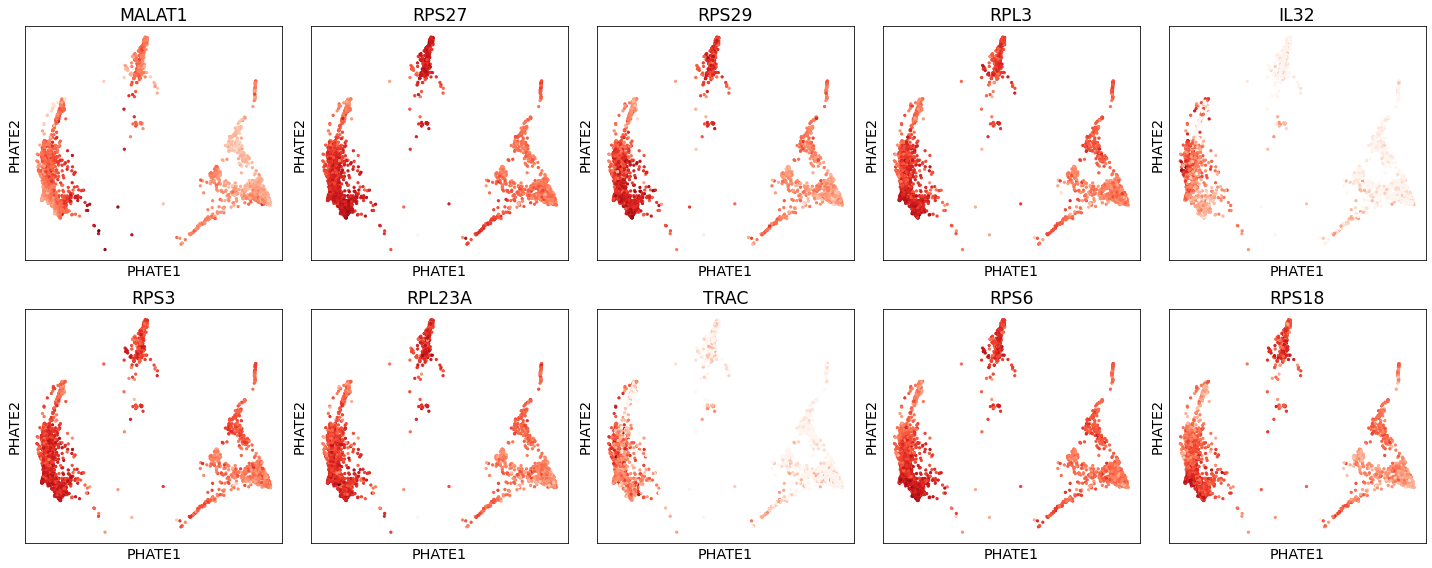

In [ ]:
print('Higher expressed in Cluster 3')
fig, axes = plt.subplots(2,5, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    exp = scprep.select.select_cols(data_sqrt, exact_word=diff_genes_0_3.index[i])
    scprep.plot.scatter2d(data_phate, c=exp, legend_anchor=(1,1), ax=ax, legend = False,
                          title=diff_genes_0_3.index[i].split(' ')[0], cmap='Reds',
                          xticks=False, yticks=False, label_prefix="PHATE", fontsize=10, s=5)

fig.tight_layout()

Higher expressed in Cluster 0


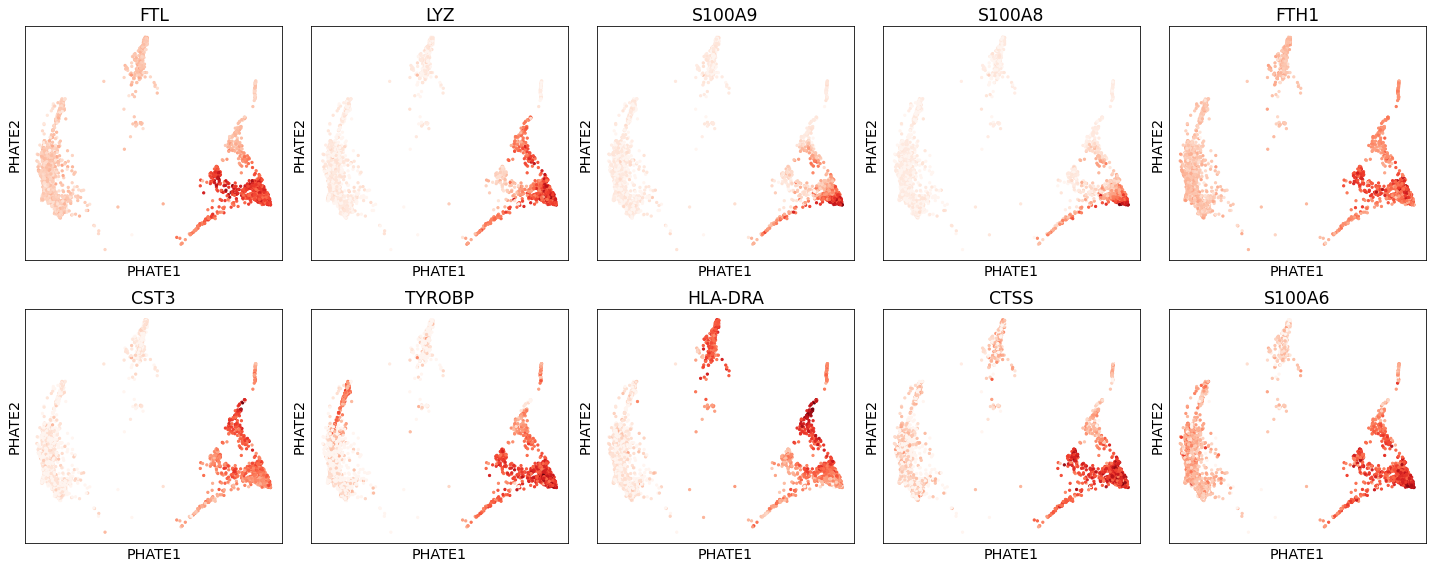

In [ ]:
print('Higher expressed in Cluster 0')

fig, axes = plt.subplots(2,5, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    exp = scprep.select.select_cols(data_sqrt, exact_word=diff_genes_0_3.index[-i-1])
    scprep.plot.scatter2d(data_phate, c=exp, legend_anchor=(1,1), ax=ax, legend = False,
                          title=diff_genes_0_3.index[-i-1].split(' ')[0], cmap='Reds',
                          xticks=False, yticks=False, label_prefix="PHATE", fontsize=10, s=5)

fig.tight_layout()

We can compare our condensed transport values with ground truth gene transport values below:

In [ ]:
%%time
diff_genes_0_3_gt = scprep.stats.differential_expression(data_sqrt.iloc[catch_op.NxTs[98]==0,:],
                                                         data_sqrt.iloc[catch_op.NxTs[98]==3,:],
                                                         measure='emd')

CPU times: user 2min 35s, sys: 421 ms, total: 2min 35s
Wall time: 2min 35s


Text(0.5, 0, 'Condensed Transport')

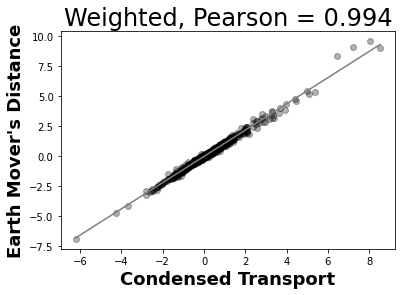

In [ ]:
import scipy
diff_genes_0_3_gt = diff_genes_0_3_gt .loc[diff_genes_0_3.index,:]
slope, intercept, r, p, stderr = scipy.stats.linregress(np.array(diff_genes_0_3['Signed Transport']),
                                                        np.array(diff_genes_0_3_gt['emd']))
plt.title("Weighted, Pearson = " +str(round(r,3)), fontsize=24)
plt.plot(np.array(diff_genes_0_3['Signed Transport']),
         intercept + slope * np.array(diff_genes_0_3['Signed Transport']), c = 'tab:grey')
plt.scatter(np.array(diff_genes_0_3['Signed Transport']), np.array(diff_genes_0_3_gt['emd']), c = 'black', alpha=.3)
plt.ylabel("Earth Mover's Distance", fontsize=18, fontweight='bold')
plt.xlabel("Condensed Transport", fontsize=18, fontweight='bold')

## Fine grained analysis of cellular subsets

Next we can look to a finer granularity of the condensation homology to identify more rare populations of cells and create more refined celltype specific signatures:

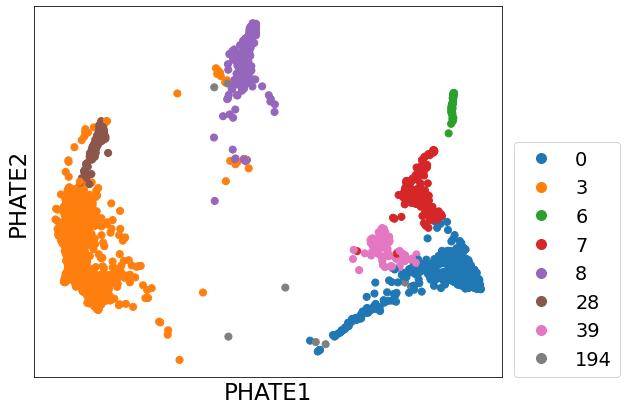

In [ ]:
scprep.plot.scatter2d(
    data_phate,
    c = catch_op.NxTs[89],
    fontsize=16,
    s=50,
    legend=True,
    ticks=False, legend_loc=(1.025,0),
    label_prefix="PHATE",
    figsize=(9, 6),
)

In [ ]:
diff_genes_3_28 = catch_op.condensed_transport(cluster_1=3, cluster_2=28, level_1=89, level_2=89)
diff_genes_3_28 = diff_genes_3_28.sort_values(by=['Signed Transport'])

Calculating Transporting Genes...
Calculated Transporting Genes in 0.04 seconds.


Now we can visualize most differntially expressed genes between clusters 0 and 3:

Higher expressed in Cluster 28


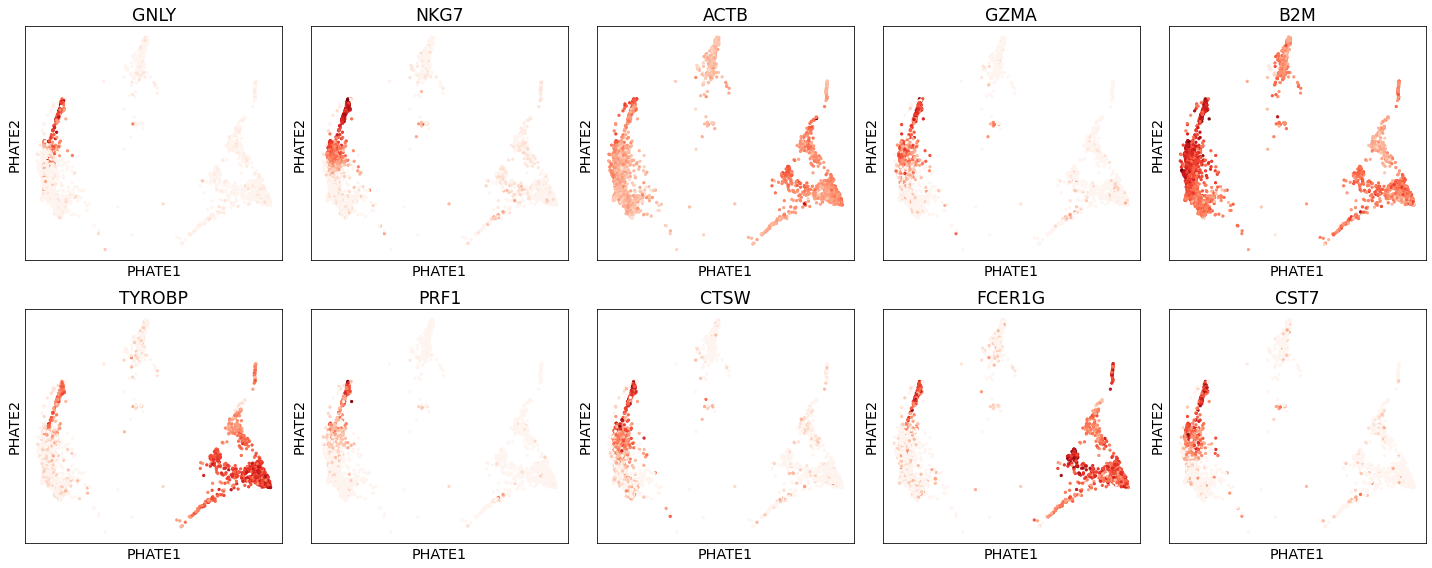

In [ ]:
print('Higher expressed in Cluster 28')
fig, axes = plt.subplots(2,5, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    exp = scprep.select.select_cols(data_sqrt, exact_word=diff_genes_3_28.index[i])
    scprep.plot.scatter2d(data_phate, c=exp, legend_anchor=(1,1), ax=ax, legend = False,
                          title=diff_genes_3_28.index[i].split(' ')[0], cmap='Reds',
                          xticks=False, yticks=False, label_prefix="PHATE", fontsize=10, s=5)

fig.tight_layout()

Higher expressed in Cluster 3


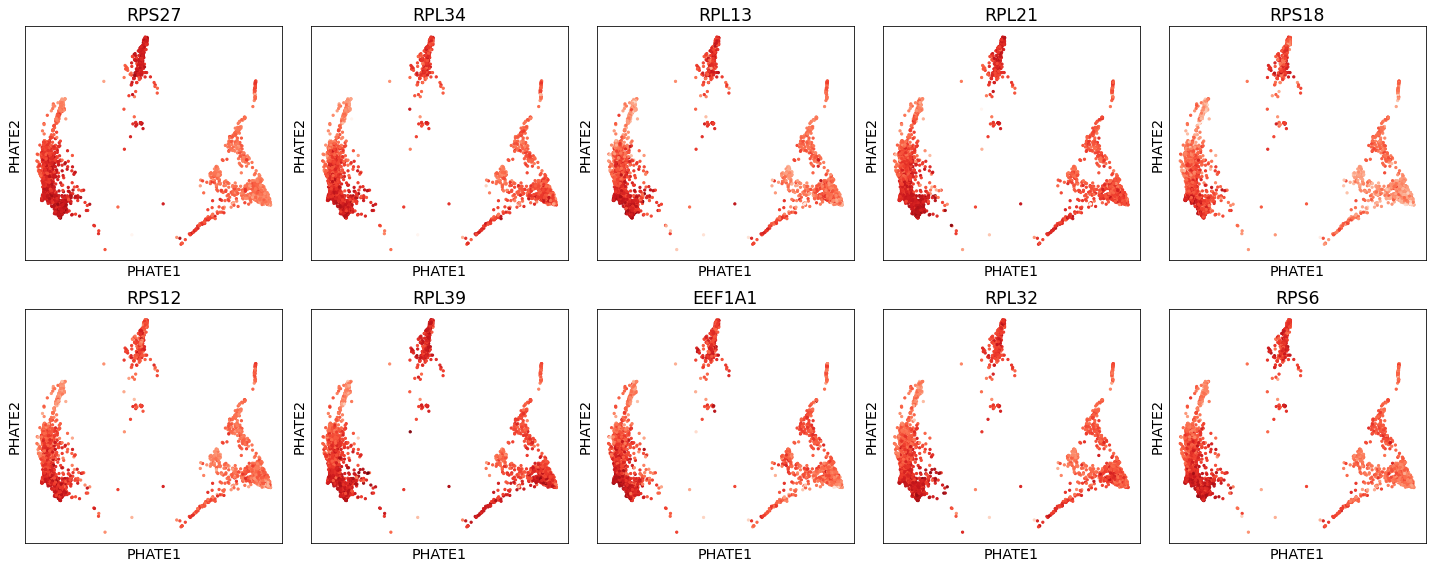

In [ ]:
print('Higher expressed in Cluster 3')

fig, axes = plt.subplots(2,5, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    exp = scprep.select.select_cols(data_sqrt, exact_word=diff_genes_3_28.index[-i-1])
    scprep.plot.scatter2d(data_phate, c=exp, legend_anchor=(1,1), ax=ax, legend = False,
                          title=diff_genes_3_28.index[-i-1].split(' ')[0], cmap='Reds',
                          xticks=False, yticks=False, label_prefix="PHATE", fontsize=10, s=5)

fig.tight_layout()

Thank you for reviewing our tutorial -- please feel free to change parameters, test out different functionality and report errors on the github page!